In [97]:
import requests

import numpy as np
import pandas as pd

In [ ]:
snp_ticker = "SPY"
btc_ticker = "BTCUSD"
gc_ticker = "GCUSD"
vix_ticker = "^VIX"

api_key = "YOUR_API_KEY"

In [ ]:
url_func = lambda ticker: "dividend-adjusted" if ticker not in [gc_ticker, vix_ticker] else "full"

def fetch_data(ticker, start_date, end_date):
    url = f"https://financialmodelingprep.com/stable/historical-price-eod/{url_func(ticker)}?" \
        + f"symbol={ticker}&from={start_date}&to={end_date}&apikey={api_key}"
    response = requests.get(url)
    data = response.json()
    df = (
        pd.DataFrame(data)
        .assign(date = lambda df_: pd.to_datetime(df_.date))
        .sort_values('date')
        .set_index('date')
        .rename(columns={'adjClose' if ticker != gc_ticker else 'close': ticker})
    )
    return df

In [107]:
btc = fetch_data(btc_ticker, "2015-01-01", "2025-10-01")
snp = fetch_data(snp_ticker, "2015-01-01", "2025-10-01")
gc = fetch_data(gc_ticker, "2015-01-01", "2025-10-01")
vix = fetch_data(vix_ticker, "2015-01-01", "2025-10-01")

In [108]:
# Save datasets locally
btc.to_csv(f"../dat/oct2025/{btc_ticker}_2015-2025.csv")
snp.to_csv(f"../dat/oct2025/{snp_ticker}_2015-2025.csv")
gc.to_csv(f"../dat/oct2025/{gc_ticker}_2015-2025.csv")
vix.to_csv(f"../dat/oct2025/{vix_ticker}_2015-2025.csv")

In [109]:
# read back in from local files
# btc = pd.read_csv(f"../dat/oct2025/{btc_ticker}_2015-2025.csv", parse_dates=['date'], index_col='date')
# snp = pd.read_csv(f"../dat/oct2025/{snp_ticker}_2015-2025.csv", parse_dates=['date'], index_col='date')
# gc = pd.read_csv(f"../dat/oct2025/{gc_ticker}_2015-2025.csv", parse_dates=['date'], index_col='date')
# vix = pd.read_csv(f"../dat/oct2025/{vix_ticker}_2015-2025.csv", parse_dates=['date'], index_col='date')

In [65]:
# Combine the dataframes on date
prices = pd.concat([snp.loc[:, [snp_ticker]], 
                    btc.loc[:, [btc_ticker]], 
                    gc.loc[:, [gc_ticker]]], axis=1, join='inner')

In [95]:
# compute daily and cumulative returns
returns = \
(prices
.assign(spy_return = lambda df_: df_[snp_ticker].pct_change(),
        btc_return = lambda df_: df_[btc_ticker].pct_change(),
        gc_return = lambda df_: df_[gc_ticker].pct_change(),
        spy_creturn = lambda df_: (1 + df_.spy_return).cumprod() - 1,
        btc_creturn = lambda df_: (1 + df_.btc_return).cumprod() - 1,
        gc_creturn = lambda df_: (1 + df_.gc_return).cumprod() - 1)
.dropna(how='any')
.loc[:, ['spy_return', 'btc_return', 'gc_return', 
        'spy_creturn', 'btc_creturn', 'gc_creturn']]
)

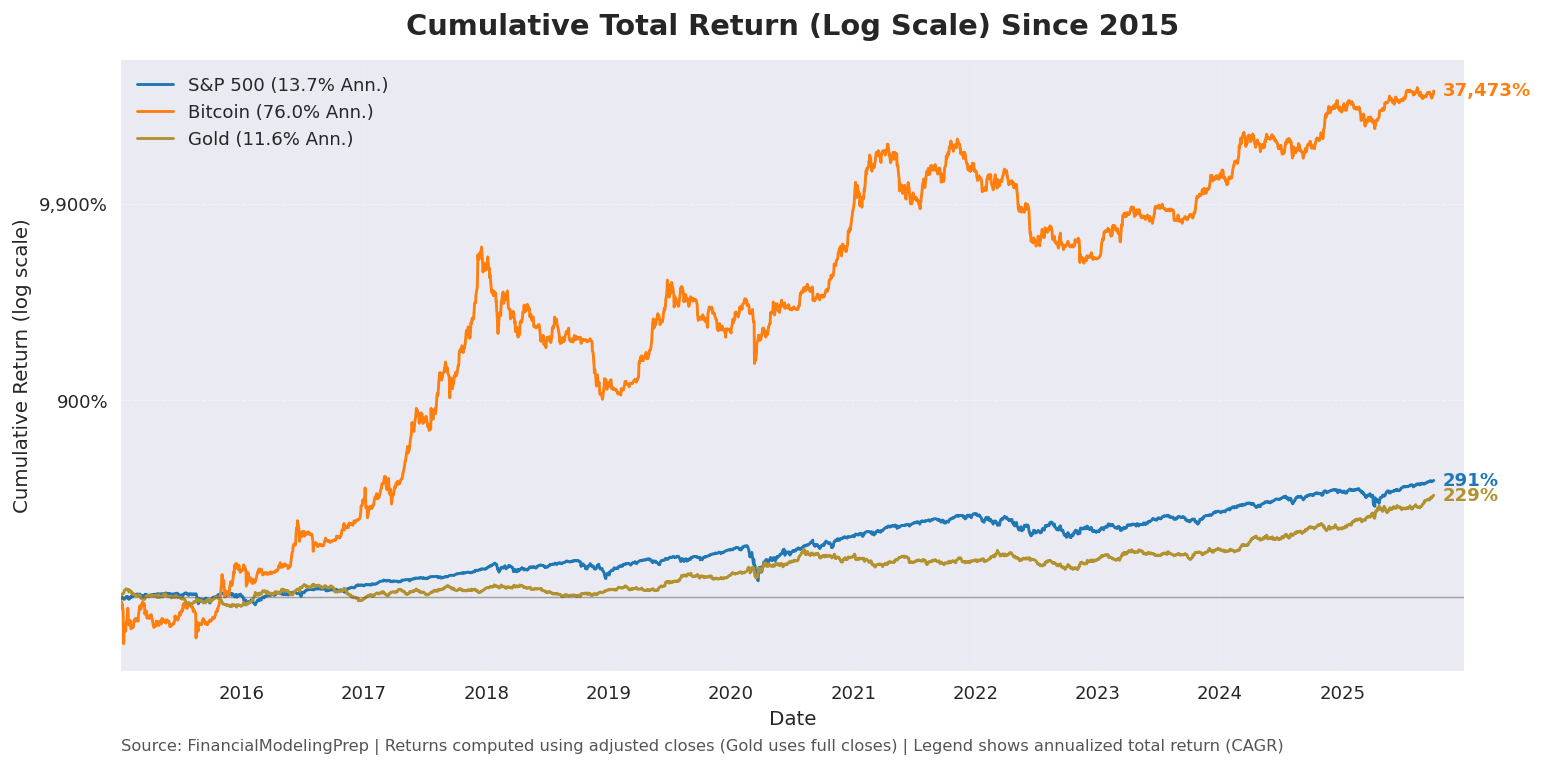

In [100]:
# Cumulative returns plot (log-scale, professional quality) with annualized returns in legend
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter, LogLocator

# Prepare growth indices (1 + cumulative return) for log scaling
creturns = returns.loc[:, ["spy_creturn", "btc_creturn", "gc_creturn"]].copy()
index_df = creturns.add(1.0)

label_map = {
    "spy_creturn": "S&P 500",
    "btc_creturn": "Bitcoin",
    "gc_creturn": "Gold"
}
color_map = {
    "S&P 500": "#1f77b4",   # blue
    "Bitcoin": "#ff7f0e",    # orange
    "Gold": "#b2912f"        # gold tone
}

# Compute annualized total returns (CAGR) for legend labels
start_date = index_df.index[0]
end_date = index_df.index[-1]
elapsed_days = (end_date - start_date).days
years = elapsed_days / 365.25
annualized = {}
for col in index_df.columns:
    ratio = index_df[col].iloc[-1] / index_df[col].iloc[0]
    ann = ratio ** (1 / years) - 1
    annualized[col] = ann

plt.style.use("seaborn-v0_8") if "seaborn-v0_8" in plt.style.available else None
fig, ax = plt.subplots(figsize=(12, 6), dpi=130)

for col in index_df.columns:
    series = index_df[col]
    base_lbl = label_map[col]
    legend_lbl = f"{base_lbl} ({annualized[col]:.1%} Ann.)"
    ax.plot(series.index, series, label=legend_lbl, color=color_map[base_lbl], linewidth=1.6)

# Log scale
ax.set_yscale("log")

# Custom formatter to show percent from base (index - 1)
@FuncFormatter
def pct_formatter(val, pos):
    pct = val - 1.0
    if pct <= 0:
        return ""
    if pct < 0.1:
        return f"{pct:.0%}"
    if pct < 1:
        return f"{pct:.0%}"
    if pct < 10:
        return f"{pct:.0%}"
    return f"{pct:,.0%}"

ax.yaxis.set_major_formatter(pct_formatter)
ax.yaxis.set_major_locator(LogLocator(base=10.0))

ax.set_title("Cumulative Total Return (Log Scale) Since 2015", fontsize=16, fontweight="bold", pad=14)
ax.set_xlabel("Date", fontsize=11)
ax.set_ylabel("Cumulative Return (log scale)", fontsize=11)
ax.grid(axis="y", which="major", alpha=0.35, linestyle="--", linewidth=0.6)
ax.grid(axis="x", alpha=0.08)

# Annotate last values to right of plot
last_date = index_df.index[-1]
extension_days = 90
ax.set_xlim(index_df.index[0], last_date + pd.Timedelta(days=extension_days))
for col in index_df.columns:
    series = index_df[col]
    base_lbl = label_map[col]
    idx_val = series.iloc[-1]
    pct_val = idx_val - 1
    ax.annotate(f"{pct_val:,.0%}",
                xy=(last_date, idx_val),
                xytext=(5, 0),
                textcoords="offset points",
                va="center",
                ha="left",
                fontsize=10,
                color=color_map[base_lbl],
                fontweight="bold")

# Baseline (index = 1 => 0% return)
ax.axhline(1.0, color="#555", linewidth=0.8, alpha=0.5)

leg = ax.legend(frameon=False, ncol=1, loc="upper left")
for txt in leg.get_texts():
    txt.set_fontsize(10)

ax.text(0.0, -0.13,
        "Source: FinancialModelingPrep | Returns computed using adjusted closes (Gold uses full closes) | Legend shows annualized total return (CAGR)",
        transform=ax.transAxes,
        fontsize=9,
        color="#555")

plt.tight_layout()
plt.show()

In [117]:
# reformat the vix
vix_df = vix.loc[:, ["close"]].rename(columns={"close": vix_ticker})

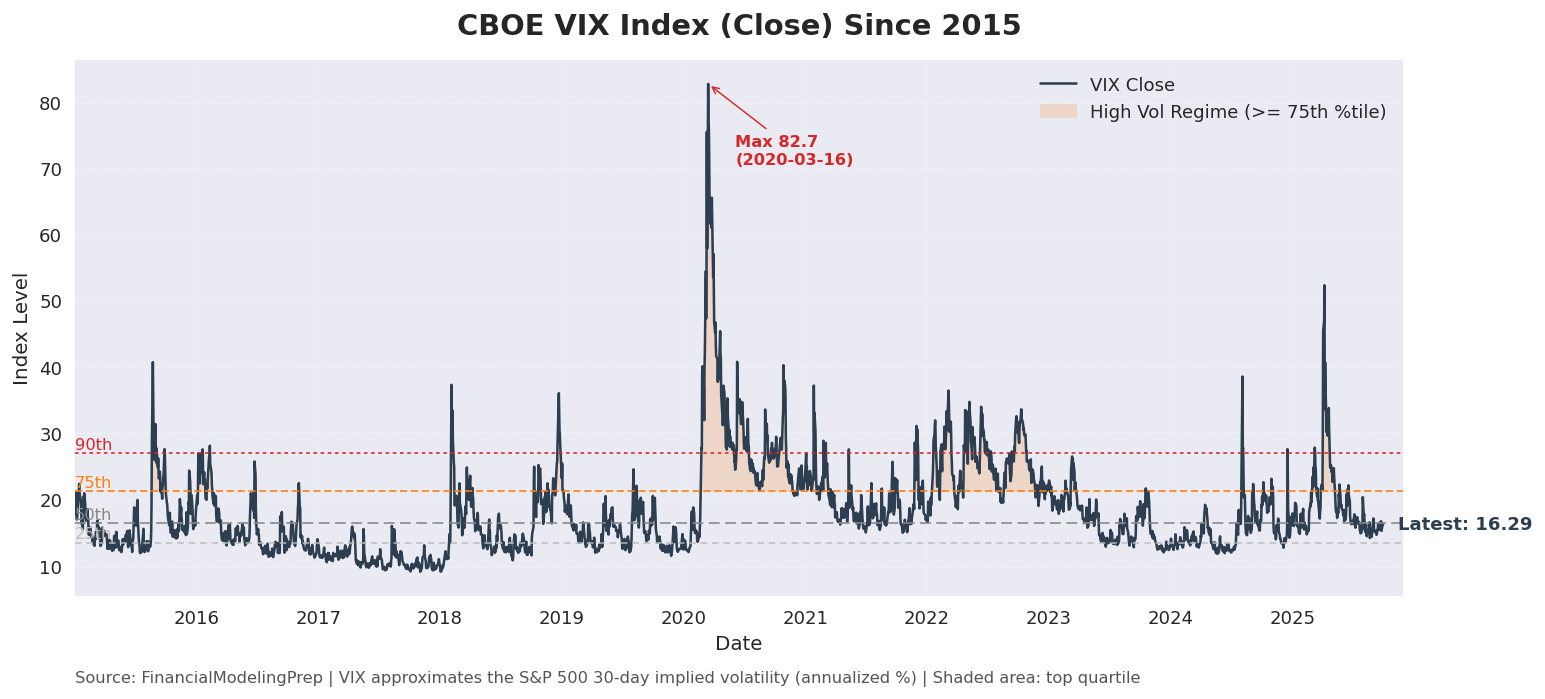

In [121]:
# Professional VIX (CBOE Volatility Index) close price chart (reverted: remove vertical high-vol bands)
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Ensure vix DataFrame exists with '^VIX' column from earlier fetch
col = vix_ticker  # '^VIX'

# Basic cleaning (drop duplicates / sort just in case)
vix_df = (
    vix_df
    .loc[:, [col]]
    .sort_index()
    .pipe(lambda df: df[~df.index.duplicated(keep='first')])
)

# Compute percentile levels for regime markers
pcts = {
    '25th': vix_df[col].quantile(0.25),
    '50th': vix_df[col].quantile(0.50),
    '75th': vix_df[col].quantile(0.75),
    '90th': vix_df[col].quantile(0.90)
}

latest_val = vix_df[col].iloc[-1]
max_val = vix_df[col].max()
max_date = vix_df[col].idxmax()

plt.style.use('seaborn-v0_8') if 'seaborn-v0_8' in plt.style.available else None
fig, ax = plt.subplots(figsize=(12, 5.5), dpi=130)
ax.plot(vix_df.index, vix_df[col], color='#2c3e50', linewidth=1.4, label='VIX Close')

# Shade high-volatility regime (>= 75th percentile) directly under the curve (area plot only)
ax.fill_between(vix_df.index, pcts['75th'], vix_df[col], where=vix_df[col] >= pcts['75th'],
                color='#ff7f0e', alpha=0.18, interpolate=True, label='High Vol Regime (>= 75th %tile)')

# Horizontal percentile lines
line_styles = {'25th': ('#bbb', 0.9, (4,3)),
               '50th': ('#888', 1.0, (6,3)),
               '75th': ('#ff7f0e', 1.0, (4,2)),
               '90th': ('#d62728', 1.0, (2,2))}
for k, (c, lw, d) in line_styles.items():
    ax.axhline(pcts[k], color=c, linewidth=lw, linestyle=(0, d), alpha=0.9)
    ax.text(vix_df.index[0], pcts[k] + 0.2, k, color=c, fontsize=9, va='bottom')

# Annotate latest value
last_date = vix_df.index[-1]
extension_days = 60
ax.set_xlim(vix_df.index[0], last_date + pd.Timedelta(days=extension_days))
ax.annotate(f"Latest: {latest_val:.2f}",
            xy=(last_date, latest_val),
            xytext=(8, 0), textcoords='offset points',
            va='center', ha='left', fontsize=10, color='#2c3e50', fontweight='bold')

# Annotate max spike (place below if too close to top to avoid title overlap)
if max_val >= pcts['90th']:
    text_offset = (15, -28)
    va_setting = 'top'
else:
    text_offset = (0, 18)
    va_setting = 'bottom'
ax.annotate(f"Max {max_val:.1f}\n({max_date.date()})",
            xy=(max_date, max_val),
            xytext=text_offset, textcoords='offset points',
            arrowprops=dict(arrowstyle='->', color='#d62728', linewidth=0.8),
            ha='left', va=va_setting, fontsize=9, color='#d62728', fontweight='bold')

# Formatting
ax.set_title('CBOE VIX Index (Close) Since 2015', fontsize=16, fontweight='bold', pad=14)
ax.set_ylabel('Index Level', fontsize=11)
ax.set_xlabel('Date', fontsize=11)
ax.grid(axis='y', alpha=0.35, linestyle='--', linewidth=0.6)
ax.grid(axis='x', alpha=0.08)

ax.text(0.0, -0.16,
        'Source: FinancialModelingPrep | VIX approximates the S&P 500 30-day implied volatility (annualized %) | Shaded area: top quartile',
        transform=ax.transAxes, fontsize=9, color='#555')

# Legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, frameon=False, loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

In [89]:
# compute rolling N-day volatility
lookback = 21

volatility = \
(returns
.assign(spy_vol = lambda df_: df_.spy_return.rolling(window=lookback).std().mul(np.sqrt(252)),
        btc_vol = lambda df_: df_.btc_return.rolling(window=lookback).std().mul(np.sqrt(252)),
        gc_vol = lambda df_: df_.gc_return.rolling(window=lookback).std().mul(np.sqrt(252)))
.dropna(how='any')
.loc[:, ['spy_vol', 'btc_vol', 'gc_vol']]
)

In [ ]:
# Professional volatility plot (annualized rolling volatility) with VIX high-regime bands
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from statistics import mean
from matplotlib.patches import Patch

# volatility DataFrame expected to have spy_vol, btc_vol, gc_vol (annualized)
vol_df = volatility.copy()
label_map = {
    'spy_vol': 'S&P 500',
    'btc_vol': 'Bitcoin',
    'gc_vol': 'Gold'
}
color_map = {
    'S&P 500': '#1f77b4',   # blue (same palette as earlier)
    'Bitcoin': '#ff7f0e',    # orange
    'Gold': '#b2912f'        # gold tone
}

plt.style.use('seaborn-v0_8') if 'seaborn-v0_8' in plt.style.available else None
fig, ax = plt.subplots(figsize=(12, 6), dpi=130)

# Plot volatility series
for col in ['spy_vol','btc_vol','gc_vol']:
    series = vol_df[col]
    lbl = label_map[col]
    ax.plot(series.index, series, label=lbl, color=color_map[lbl], linewidth=1.4)

# Add latest value annotations to the right
last_date = vol_df.index[-1]
extension_days = 40
ax.set_xlim(vol_df.index[0], last_date + pd.Timedelta(days=extension_days))
for col in ['spy_vol','btc_vol','gc_vol']:
    series = vol_df[col]
    lbl = label_map[col]
    y = series.iloc[-1]
    ax.annotate(f"{y:.1%}",
                xy=(last_date, y),
                xytext=(6, 0),
                textcoords='offset points',
                va='center',
                ha='left',
                fontsize=10,
                color=color_map[lbl],
                fontweight='bold')

# Compute and draw long-run average lines (dashed)
for col in ['spy_vol','btc_vol','gc_vol']:
    series = vol_df[col]
    avg = series.mean()
    lbl = label_map[col]
    ax.hlines(avg, xmin=series.index[0], xmax=last_date, colors=color_map[lbl], linestyles='dashed', linewidth=0.9, alpha=0.55)

# --- NEW: Shade periods where VIX > 75th percentile for >=10 consecutive days ---
try:
    # Use existing vix_df if available
    vix_series = vix_df[vix_ticker].sort_index()
    vix_threshold = vix_series.quantile(0.75)
    high_mask = vix_series >= vix_threshold
    # Identify contiguous segments
    groups = (high_mask.ne(high_mask.shift())).cumsum()
    shaded_periods = []
    for g_id, g_idx in vix_series.groupby(groups).groups.items():
        idx_slice = vix_series.loc[g_idx]
        if high_mask.loc[idx_slice.index[0]] and len(idx_slice) >= 10:
            start = idx_slice.index[0]
            end = idx_slice.index[-1]
            shaded_periods.append((start, end))
    first = True
    for start, end in shaded_periods:
        ax.axvspan(start, end, color='#9467bd', alpha=0.10, label='VIX > 75th % (>=10d)' if first else None)
        first = False
except Exception as e:
    # Silent fail if vix_df not present
    pass

# Formatting
ax.set_title('Rolling 21-Day Annualized Volatility', fontsize=16, fontweight='bold', pad=14)
ax.set_ylabel('Annualized Volatility', fontsize=11)
ax.set_xlabel('Date', fontsize=11)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.grid(axis='y', alpha=0.35, linestyle='--', linewidth=0.6)
ax.grid(axis='x', alpha=0.08)

# Legend with average vol appended (+ optional VIX regime patch)
legend_labels = []
handles = []
# Collect existing line handles
for line in ax.get_lines():
    name = line.get_label()
    if name in label_map.values():
        # Map back to key
        key = [k for k,v in label_map.items() if v == name][0]
        avg = vol_df[key].mean()
        line.set_label(f"{name} (Avg {avg:.1%})")

# If shaded periods were added, ensure one patch appears in legend
if 'shaded_periods' in locals() and any(shaded_periods):
    patch = Patch(facecolor='#9467bd', alpha=0.10, edgecolor='none', label='VIX > 75th % (>=10d)')
    existing_handles, existing_labels = ax.get_legend_handles_labels()
    existing_handles.append(patch)
    ax.legend(existing_handles, existing_labels, frameon=False, ncol=1, loc='upper right')
else:
    ax.legend(frameon=False, ncol=1, loc='upper right')

# Footnote
footnote_extra = ' | Shaded bands: periods VIX > 75th percentile for ≥10 days' if 'shaded_periods' in locals() and any(shaded_periods) else ''
ax.text(0.0, -0.13,
        f'Source: FinancialModelingPrep | 21-day rolling stdev of daily returns * sqrt(252) | Dotted lines = sample mean{footnote_extra}',
        transform=ax.transAxes,
        fontsize=9,
        color='#555')

plt.tight_layout()
plt.show()

In [93]:
# compute rolling N-day correlation
lookback = 63

correlation = \
(returns
.assign(spy_btc = lambda df_: df_.spy_return.rolling(window=lookback).corr(df_.btc_return),
        spy_gc = lambda df_: df_.spy_return.rolling(window=lookback).corr(df_.gc_return),
        btc_gc = lambda df_: df_.btc_return.rolling(window=lookback).corr(df_.gc_return))
.dropna(how='any')
.loc[:, ['spy_btc', 'spy_gc', 'btc_gc']]
)

In [124]:
# Professional rolling correlation plot (Bitcoin vs Gold removed) - fixed legend mapping + VIX high-regime shading
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.patches import Patch

# correlation DataFrame expected columns: spy_btc, spy_gc, btc_gc (we ignore btc_gc per request)
cor_df = correlation.copy()
series_order = ["spy_btc", "spy_gc"]
label_map = {
    "spy_btc": "S&P 500 vs Bitcoin",
    "spy_gc": "S&P 500 vs Gold"
}
color_map = {
    "S&P 500 vs Bitcoin": "#9467bd",  # purple
    "S&P 500 vs Gold": "#1f77b4"       # blue
}

plt.style.use('seaborn-v0_8') if 'seaborn-v0_8' in plt.style.available else None
fig, ax = plt.subplots(figsize=(12, 6), dpi=130)

# Diversification sweet-spot band (|corr| < 0.3)
ax.axhspan(-0.3, 0.3, color="#dddddd", alpha=0.35, zorder=0)

# --- NEW: Shade periods where VIX > 75th percentile for >=10 consecutive days (match volatility plot logic) ---
shaded_periods = []
try:
    vix_series = vix_df[vix_ticker].sort_index()
    vix_threshold = vix_series.quantile(0.75)
    high_mask = vix_series >= vix_threshold
    groups = (high_mask.ne(high_mask.shift())).cumsum()
    for g_id, g_idx in vix_series.groupby(groups).groups.items():
        idx_slice = vix_series.loc[g_idx]
        if high_mask.loc[idx_slice.index[0]] and len(idx_slice) >= 10:
            start = idx_slice.index[0]
            end = idx_slice.index[-1]
            shaded_periods.append((start, end))
    first = True
    for start, end in shaded_periods:
        ax.axvspan(start, end, color='#9467bd', alpha=0.07, label='VIX > 75th % (>=10d)' if first else None, zorder=0.5)
        first = False
except Exception:
    pass

# Plot and capture line handles explicitly
line_handles = []
for col in series_order:
    s = cor_df[col]
    lbl = label_map[col]
    line, = ax.plot(s.index, s, color=color_map[lbl], linewidth=1.4)
    line_handles.append(line)

last_date = cor_df.index[-1]
extension_days = 40
ax.set_xlim(cor_df.index[0], last_date + pd.Timedelta(days=extension_days))

# Horizontal reference lines
for y, style, alpha in [(0, '-', 0.7), (0.5, '--', 0.5), (-0.5, '--', 0.5), (1, ':', 0.4), (-1, ':', 0.4)]:
    ax.axhline(y, color="#444", linewidth=0.9, linestyle=style, alpha=alpha)

# Annotate last values
for col in series_order:
    s = cor_df[col]
    lbl = label_map[col]
    y = s.iloc[-1]
    ax.annotate(f"{y:.2f}",
                xy=(last_date, y),
                xytext=(6, 0),
                textcoords='offset points',
                va='center',
                ha='left',
                fontsize=10,
                color=color_map[lbl],
                fontweight='bold')

# Set legend labels on handles AFTER computing averages to ensure mapping is correct
for line, col in zip(line_handles, series_order):
    avg = cor_df[col].mean()
    line.set_label(f"{label_map[col]} (Avg {avg:+.2f})")

# Build legend (include shading patch if shaded periods exist but no labeled span due to error)
handles, labels = ax.get_legend_handles_labels()
if shaded_periods and 'VIX > 75th % (>=10d)' not in labels:
    handles.append(Patch(facecolor='#9467bd', alpha=0.07, edgecolor='none', label='VIX > 75th % (>=10d)'))
leg = ax.legend(handles, labels, frameon=False, ncol=1, loc='upper right')
for txt in leg.get_texts():
    txt.set_fontsize(10)

ax.set_title('Rolling 63-Day Correlations', fontsize=16, fontweight='bold', pad=14)
ax.set_ylabel('Correlation', fontsize=11)
ax.set_xlabel('Date', fontsize=11)
ax.set_ylim(-1.05, 1.05)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.grid(axis='y', alpha=0.30, linestyle='--', linewidth=0.6)
ax.grid(axis='x', alpha=0.08)

footnote_extra = ' | Vertical bands: periods VIX > 75th percentile for ≥10 days' if shaded_periods else ''
ax.text(0.0, -0.13,
        f'Source: FinancialModelingPrep | 63-day rolling Pearson correlation of daily returns | Shaded gray band: |corr| < 0.3{footnote_extra}',
        transform=ax.transAxes,
        fontsize=9,
        color='#555')

plt.tight_layout()
plt.show()

In [126]:
# Drawdown analysis
def compute_drawdowns(creturns):
    """Compute drawdowns from cumulative returns DataFrame."""
    dd = creturns.copy()
    dd = dd + 1.0
    rolling_max = dd.cummax()
    drawdown = (dd / rolling_max) - 1.0
    return drawdown

drawdowns = compute_drawdowns(returns.loc[:, ["spy_creturn", "btc_creturn", "gc_creturn"]])

In [128]:
# Professional drawdown chart with max drawdown annotations
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.patches import Patch

# drawdowns DataFrame assumed prepared earlier with columns: spy_creturn, btc_creturn, gc_creturn derived drawdowns
# Current 'drawdowns' holds ( (1+creturn)/(rolling_max) - 1 ) values (i.e., 0 at peaks, negative in drawdown)

dd_df = drawdowns.copy()
label_map = {
    'spy_creturn': 'S&P 500',
    'btc_creturn': 'Bitcoin',
    'gc_creturn': 'Gold'
}
color_map = {
    'S&P 500': '#1f77b4',
    'Bitcoin': '#ff7f0e',
    'Gold': '#b2912f'
}

plt.style.use('seaborn-v0_8') if 'seaborn-v0_8' in plt.style.available else None
fig, ax = plt.subplots(figsize=(12, 6), dpi=130)

series_cols = ['spy_creturn','btc_creturn','gc_creturn']
last_date = dd_df.index[-1]
extension_days = 40
ax.set_xlim(dd_df.index[0], last_date + pd.Timedelta(days=extension_days))

# Plot drawdowns as filled areas under zero (baseline)
for col in series_cols:
    s = dd_df[col]
    lbl = label_map[col]
    ax.plot(s.index, s, color=color_map[lbl], linewidth=1.2)
    ax.fill_between(s.index, s, 0, where=s < 0, color=color_map[lbl], alpha=0.10, linewidth=0)

# Identify max drawdown (most negative) and annotate; also annotate latest drawdown
for col in series_cols:
    s = dd_df[col]
    lbl = label_map[col]
    min_val = s.min()
    min_idx = s.idxmin()
    latest_val = s.iloc[-1]

    # Max DD annotation
    ax.annotate(f"Max {min_val:.0%}\n({min_idx.date()})",
                xy=(min_idx, min_val),
                xytext=(0, -22), textcoords='offset points',
                ha='center', va='top',
                fontsize=9, color=color_map[lbl], fontweight='bold',
                arrowprops=dict(arrowstyle='->', color=color_map[lbl], linewidth=0.8, shrinkA=3, shrinkB=3))

    # Latest DD annotation to right
    ax.annotate(f"{latest_val:.0%}",
                xy=(last_date, latest_val),
                xytext=(6, 0), textcoords='offset points',
                ha='left', va='center',
                fontsize=10, color=color_map[lbl], fontweight='bold')

# Legend: include max drawdown in label
handles, labels = [], []
for col in series_cols:
    s = dd_df[col]
    lbl = label_map[col]
    max_dd = s.min()
    line = ax.plot([], [], color=color_map[lbl], linewidth=2, label=f"{lbl} (Max {max_dd:.0%})")[0]
    handles.append(line)

leg = ax.legend(handles=handles, frameon=False, loc='lower left', fontsize=10, ncol=1)

# Formatting
ax.set_title('Historical Drawdowns Since 2015', fontsize=16, fontweight='bold', pad=14)
ax.set_ylabel('Drawdown (from peak)', fontsize=11)
ax.set_xlabel('Date', fontsize=11)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Set y-limits to include a small margin below the worst drawdown
min_overall = dd_df.min().min()
ax.set_ylim(min_overall * 1.10, 0.02)

ax.grid(axis='y', alpha=0.35, linestyle='--', linewidth=0.6)
ax.grid(axis='x', alpha=0.08)

# Zero line (peak baseline)
ax.axhline(0, color='#444', linewidth=0.9, alpha=0.6)

# Footnote
ax.text(0.0, -0.13,
        'Source: FinancialModelingPrep | Drawdown = (Cumulative Growth / Rolling Peak) - 1 | Areas show depth and duration of capital impairment',
        transform=ax.transAxes,
        fontsize=9,
        color='#555')

plt.tight_layout()
plt.show()

In [125]:
# Correlation illustration: scatter plots for target correlations 0, 0.3, 0.6, 1.0
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Reproducibility
rng = np.random.default_rng(42)

# Parameters
n = 400  # sample size per panel
means = np.array([0.0, 0.0])
stds = np.array([1.0, 1.0])
target_corrs = [0.0, 0.3, 0.6, 1.0]

# Helper to generate two series with a specified correlation using Cholesky
samples = {}
for r in target_corrs:
    cov = np.array([[1.0, r],[r, 1.0]])
    L = np.linalg.cholesky(cov + 1e-12*np.eye(2))  # numeric stability
    z = rng.standard_normal((2, n))
    xy = L @ z
    samples[r] = xy  # shape (2, n)

plt.style.use('seaborn-v0_8') if 'seaborn-v0_8' in plt.style.available else None
fig, axes = plt.subplots(2, 2, figsize=(11, 9), dpi=130)
fig.suptitle('What Different Correlation Levels Look Like', fontsize=16, fontweight='bold', y=0.97)

scatter_kwargs = dict(s=18, alpha=0.55, edgecolor='none')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd']

# Shared axis limits for comparability
axis_lim = (-3.2, 3.2)

for ax, r, c in zip(axes.ravel(), target_corrs, colors):
    x, y = samples[r]
    # Compute realized correlation (may differ slightly from target due to finite sample)
    realized = np.corrcoef(x, y)[0,1]

    ax.scatter(x, y, color=c, **scatter_kwargs)

    # Optional: add least squares regression line except when |r| < ~1e-8 (flat)
    if abs(r) > 1e-8:
        slope = (y @ x) / (x @ x)
        xs = np.linspace(axis_lim[0], axis_lim[1], 100)
        ax.plot(xs, slope*xs, color='#333', linewidth=1.1, alpha=0.9, linestyle='--')

    ax.set_xlim(axis_lim)
    ax.set_ylim(axis_lim)
    ax.set_xticks([-3,-2,-1,0,1,2,3])
    ax.set_yticks([-3,-2,-1,0,1,2,3])
    ax.grid(alpha=0.18, linestyle='--', linewidth=0.6)

    title_corr = f"ρ = {r:.1f} (realized {realized:+.2f})"
    ax.set_title(title_corr, fontsize=12, pad=8, fontweight='bold')

    # Light zero axes for orientation
    ax.axhline(0, color='#555', linewidth=0.7, alpha=0.35)
    ax.axvline(0, color='#555', linewidth=0.7, alpha=0.35)

# Axis labels on left and bottom only for cleanliness
for ax in axes[0,1].get_yaxis().get_ticklabels():
    pass  # kept for conceptual symmetry

axes[1,0].set_xlabel('X', fontsize=11)
axes[1,1].set_xlabel('X', fontsize=11)
axes[0,0].set_ylabel('Y', fontsize=11)
axes[1,0].set_ylabel('Y', fontsize=11)

fig.text(0.0, 0.01,
         'Illustration: random draws from a bivariate normal with specified population correlation ρ. Each panel shows 400 points; dashed line is least-squares fit.\nRealized sample correlation differs slightly from target due to finite sample effects.',
         fontsize=9, color='#555')

plt.tight_layout(rect=(0,0.02,1,0.955))
plt.show()